In [128]:
import copy
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import matplotlib.lines as lines

from random import randrange
from scipy import stats

In [176]:
def load_csv(path_to_data):
    with open(path_to_data) as f:
        data = []

        col_names = None

        for row in csv.reader(f):
            if not col_names:
                col_names = row
                col_names[0] = 'age'
            else:
                data.append([float(i) for i in row])

    return col_names, data

def prepare_data(data):
    """
    Use z-score of input feature values
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
    https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)
    """
    feature_vectors = []
    output_classes = []
    
    for entry in data:
        feature_vectors.append(entry[0:-1])
        output_classes.append([entry[-1]])
        
    feature_vectors = np.array(feature_vectors).astype(np.float64)
    feature_vectors = np.apply_along_axis(stats.zscore, 0, feature_vectors)
        
    return feature_vectors, np.array(output_classes), np.hstack((feature_vectors, np.array(output_classes)))

def split_data(all_data, train_perc=0.85, seed=0):
    np.random.seed(seed)
    num_train = math.floor(train_perc * len(all_data))
    
    use_data = copy.deepcopy(all_data)
    
    np.random.shuffle(use_data)
    
    training = []
    while len(training) < num_train:
        sample, use_data = use_data[-1], use_data[:-1]
        
        training.append(sample)
    testing = use_data
    
    training_xs = []
    training_ys = []
    for ind in range(len(training)):
        training_xs.append(training[ind][0:-1])
        training_ys.append(training[ind][-1])
    
    testing_xs = []
    testing_ys = []
    for ind in range(len(testing)):
        testing_xs.append(testing[ind][0:-1])
        testing_ys.append(testing[ind][-1])
        
    training_ys = np.expand_dims(training_ys, 1)
    testing_ys = np.expand_dims(testing_ys, 1)
        
    return ((np.array(training_xs), np.array(training_ys).astype(int)), (np.array(testing_xs), np.array(testing_ys).astype(int)))

In [177]:
def sigmoid(func):
    return 1 / (1 + np.exp(-func))

def calc_gradient((xs, ys), w):
    raw_scores = np.dot(xs, w)
    adjusted_predictions = sigmoid(raw_scores)
    errors = ys - adjusted_predictions
    gradient = -np.dot(xs.transpose(), errors)
    return gradient

def gradient_descent((orig_xs, ys), epochs=100000, lr=1e-6, prec=1e-15):
    intercept = np.ones((orig_xs.shape[0], 1))
    xs = np.hstack((intercept, orig_xs))
        
    w = np.zeros(xs.shape[1])
    w = np.expand_dims(w, 1)
    w = w.astype(np.float128)
        
    for epoch_num in range(epochs):
        gradient = calc_gradient((xs, ys), w)
        update = lr * gradient
        w = w - update
        if (update < prec).all():
            return w
        
    return w

def eval_set((set_xs, set_ys), w):
    with_intercept = np.ones((set_xs.shape[0], 1))
    use_xs = np.hstack((with_intercept, set_xs))
    raw_scores = np.dot(use_xs, w)
    predictions = np.round(sigmoid(raw_scores)).astype(int)
    error = (predictions != set_ys).sum().astype(float) / len(set_ys)
    accuracy = np.mean(predictions == set_ys)
    return error, accuracy, predictions

def split_into_k((xs, ys), k):
    xs_copy = list(copy.deepcopy(xs))
    ys_copy = list(copy.deepcopy(ys))
    
    xs_ys_pairs = []

    fold_len = int(len(xs) / k)
    
    for _ in range(k):
        this_fold_xs = []
        this_fold_ys = []
        
        while len(this_fold_xs) < fold_len:
            ind = randrange(len(xs_copy))
            this_fold_xs.append(xs_copy.pop(ind))
            this_fold_ys.append(ys_copy.pop(ind))
        
        xs_ys_pairs.append((np.array(this_fold_xs), np.array(this_fold_ys)))
        
    return xs_ys_pairs

In [178]:
names, data_points = load_csv('../data/orig_raw.csv')
all_xs, all_ys, adjusted_data = prepare_data(data_points)
training, testing = split_data(adjusted_data, train_perc=0.90)
print('{} training samples'.format(len(training[0])))
print('{} testing samples'.format(len(testing[0])))

272 training samples
31 testing samples


In [179]:
weights = gradient_descent(training, epochs=250000, lr=0.0001)
train_error, train_accuracy, _ = eval_set(training, weights)
test_error, test_accuracy, _ = eval_set(testing, weights)
print('train_error={} train_accuracy={}'.format(train_error, train_accuracy))
print('test_error={} test_accuracy={}'.format(test_error, test_accuracy))

train_error=0.165441176471 train_accuracy=0.834558823529
test_error=0.161290322581 test_accuracy=0.838709677419


In [180]:
ks = [2, 5, 10]
k_errors = []
k_weights = []

for k in ks:
    all_training_xs_ys_pairs = split_into_k(training, k)
    holdout_errors = []
    holdout_weights = []
    
    for holdout_ind in range(len(all_training_xs_ys_pairs)):
        training_copy = copy.deepcopy(all_training_xs_ys_pairs)
        holdout_xs, holdout_ys = training_copy.pop(holdout_ind)
        xs = training_copy[0][0]
        ys = training_copy[0][1]
        
        for ind in range(1, len(training_copy)):
            a_fold_xs, a_fold_ys = training_copy[ind]
            xs = np.concatenate((xs, a_fold_xs), axis=0)
            ys = np.concatenate((ys, a_fold_ys), axis=0)
            
        weights = gradient_descent((xs, ys), epochs=100000, lr=0.0001)
        error, accuracy, _ = eval_set((holdout_xs, holdout_ys), weights)

        holdout_errors.append(error)
        holdout_weights.append(weights)
        
    min_error_ind = holdout_errors.index(min(holdout_errors))
        
    holdout_error = holdout_errors[min_error_ind]
    k_errors.append(holdout_error)
    best_weight = holdout_weights[min_error_ind]
    k_weights.append(best_weight)
    
    print('k={} error={}').format(k, holdout_error)
    
lowest_error_ind = k_errors.index(min(k_errors))
lowest_error = k_errors[lowest_error_ind]
best_weights = k_weights[lowest_error_ind]

print('lowest_error={}'.format(lowest_error))
print('best_weights={}'.format(best_weights))

k=2 error=0.213235294118
k=5 error=0.148148148148
k=10 error=0.037037037037
lowest_error=0.037037037037
best_weights=[[ 0.055806854]
 [-0.075386883]
 [-0.81308071]
 [ 0.80211863]
 [-0.30582136]
 [-0.32180706]
 [-0.14873631]
 [ 0.12502016]
 [ 0.43359927]
 [-0.39420507]
 [-0.67224902]
 [ 0.37275792]
 [-0.85805599]
 [-0.59274508]]


In [181]:
all_error, all_accuracy, all_ys_pred = eval_set((all_xs, all_ys), best_weights)
print('all_error={} all_accuracy={}'.format(all_error, all_accuracy))

all_error=0.148514851485 all_accuracy=0.851485148515


In [182]:
def calc_result_stats((xs, ys, pred_ys)):
    # true negative: healthy and predicted healthy
    # true positive: heart disease and predicted heart disease
    # false positive: healthy and predicted heart disease
    # false negative: heart disease and predicted healthy
    
    tps = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 1 and pred_ys[ind] == 1])
    tns = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 0 and pred_ys[ind] == 0])
    fps = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 0 and pred_ys[ind] == 1])
    fns = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 1 and pred_ys[ind] == 0])

    return tps, tns, fps, fns

def plot_data((xs, ys, pred_ys), axis_info):
    tps, tns, fps, fns = calc_result_stats((xs, ys, pred_ys))
    # green/red: healthy/not healthy
    # plus/x: correct prediction / incorrect prediction
    plt.scatter(tps[:, 0], tps[:, 1], label='predicted heart disease (correct)', color='red', marker='+')
    plt.scatter(tns[:, 0], tns[:, 1], label='predicted healthy (correct)', color='green', marker='+')
    plt.scatter(fps[:, 0], fps[:, 1], label='predicted heart disease (wrong)', color='green', marker='x')
    plt.scatter(fns[:, 0], fns[:, 1], label='predicted healthy (wrong)', color='red', marker='x')
        
    plt.xlabel('{} ({})'.format(axis_info[0][1], axis_info[0][2]))
    plt.ylabel('{} ({})'.format(axis_info[1][1], axis_info[1][2]))
    plt.title('{} vs. {}'.format(axis_info[1][1], axis_info[0][1]))
    plt.legend()
    plt.show()
    
def plot_interesting((all_xs, all_ys, all_pred_ys)):
    interesting_inds = [0, 3, 4, 7] # age, resting blood pressure, cholesterol, max heart rate
    adjusted_names = ['Age', 'Resting Blood Pressure', 'Cholesterol', 'Max Heart Rate']
    units = ['years', 'mmHg', 'mg/dl', 'bpm']

    axis_info = [(ind, name, units) for ind, name, units in zip(interesting_inds, adjusted_names, units)]

    for ind0, dim0 in enumerate(interesting_inds):
        for ind1, dim1 in enumerate(interesting_inds):
            if ind0 == ind1:
                continue
            dim0_vals = np.expand_dims(all_xs[:, dim0], 1)
            dim1_vals = np.expand_dims(all_xs[:, dim1], 1)

            xs = np.hstack((dim0_vals, dim1_vals))

            plot_data((xs, all_ys, all_pred_ys), [axis_info[ind0], axis_info[ind1]])
            
def report_results((all_xs, all_ys, all_ys_pred)):
    tps, tns, fps, fns = calc_result_stats((all_xs, all_ys, all_ys_pred))
    print('true positives (heart disease and predicted heart disease) = {}'.format(len(tps)))
    print('true negatives (healthy and predicted healthy) = {}'.format(len(tns)))
    print('false positives (healthy and predicted heart disease) = {}'.format(len(fps)))
    print('false negatives (heart disease and predicted healthy) = {}'.format(len(fns)))
    plot_interesting((all_xs, all_ys, all_ys_pred))

-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 149
true negatives (healthy and predicted healthy) = 109
false positives (healthy and predicted heart disease) = 29
false negatives (heart disease and predicted healthy) = 16


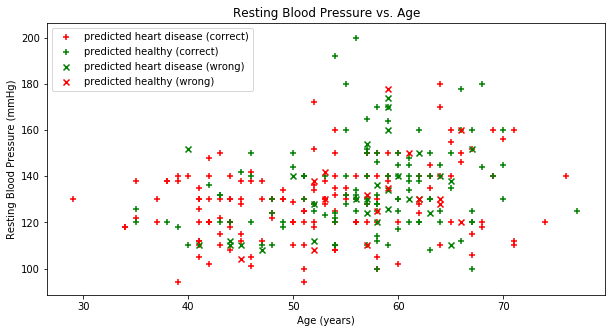

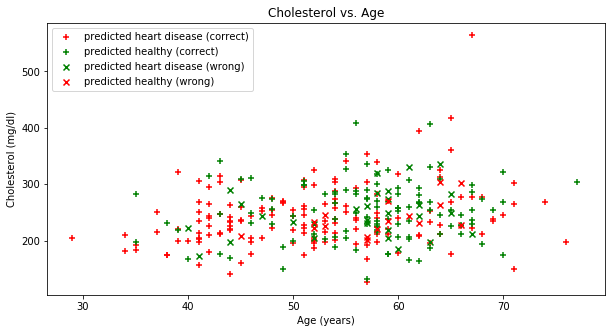

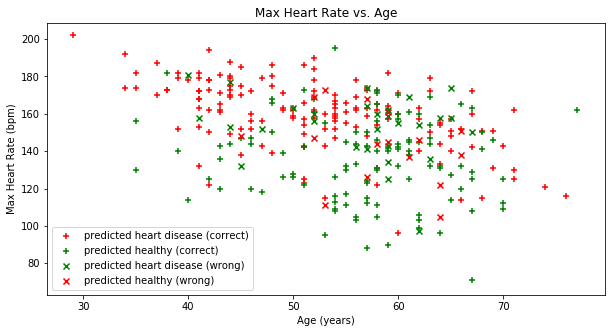

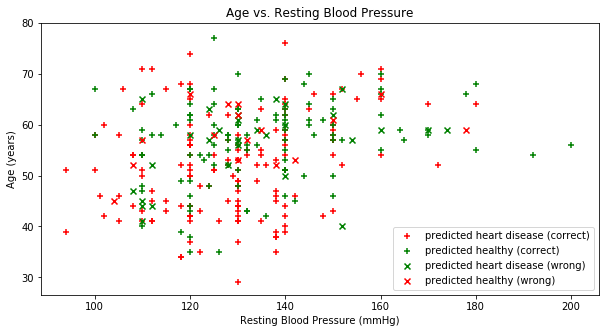

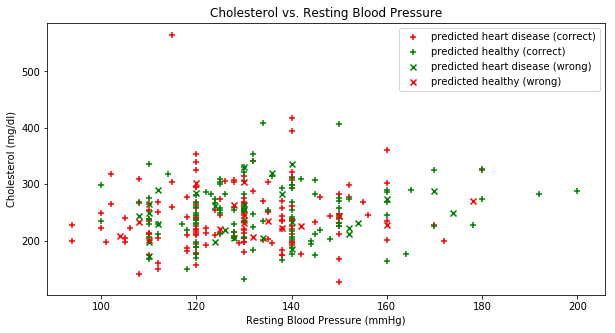

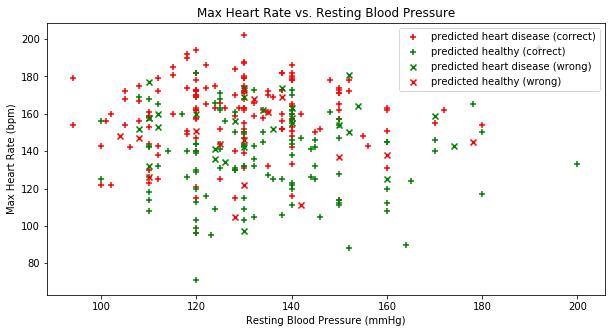

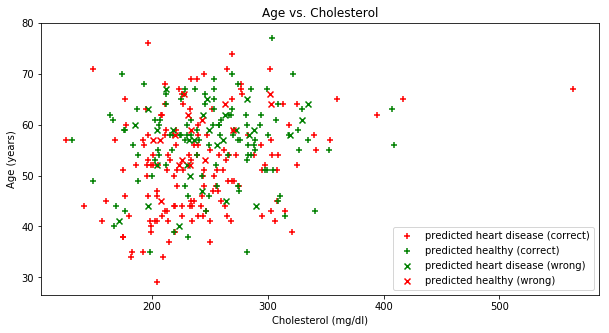

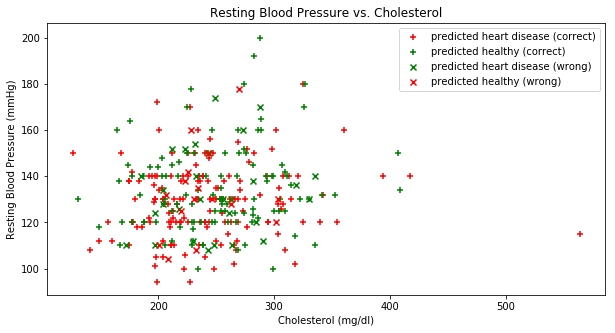

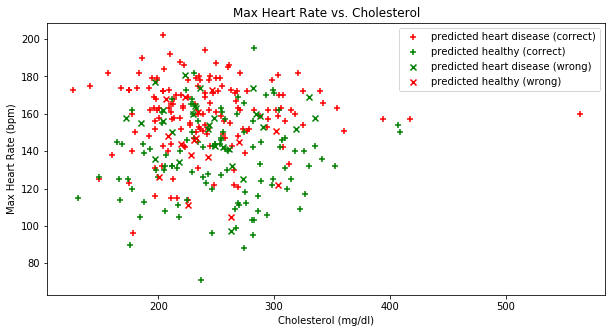

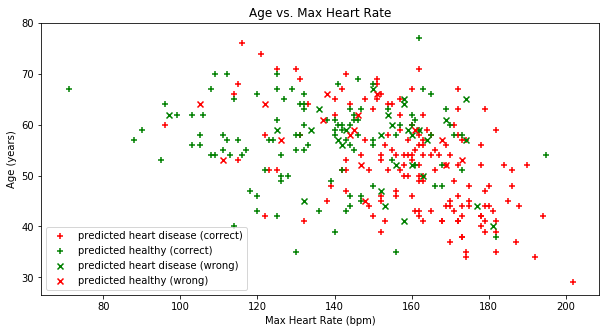

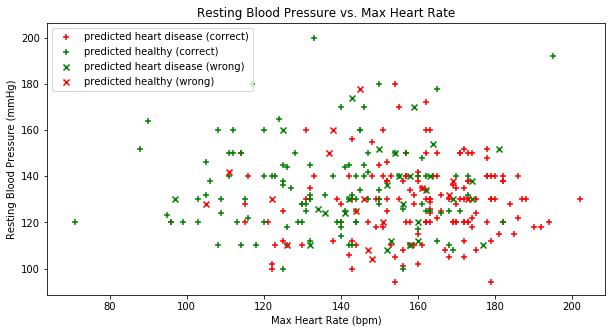

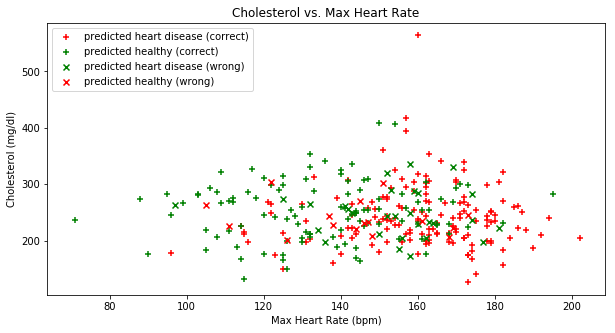

In [183]:
_, data_points = load_csv('../data/orig_raw.csv')
all_xs = np.array(data_points)[:, range(13)]

print('-----results on entire dataset-----')
report_results((all_xs, all_ys, all_ys_pred))